In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
import yaml
from torch.utils.data import DataLoader, random_split

from rhythmic_relationships.model_utils import get_loss_fn, get_model_name, load_config, save_model, save_checkpoint
from rhythmic_relationships import DATASETS_DIR, MODELS_DIR
from rhythmic_relationships.data import PartPairDatasetSequential
from rhythmic_relationships.model import TransformerEncoderDecoder
from rhythmic_relationships.vocab import get_vocab_sizes

from . import train_transformer_encoder_decoder

DEFAULT_CONFIG_FILEPATH = "config_encdec.yml"

DEVICE = torch.device(
    "mps"
    if torch.backends.mps.is_built()
    else torch.device("cuda:0")
    if torch.cuda.device_count() > 0
    else torch.device("cpu")
)

model_name = get_model_name()
print(f"{model_name=}\n")

config = load_config(DEFAULT_CONFIG_FILEPATH)
print(yaml.dump(config))

model_name='ooporphyrin_2305291424'

batch_size: 8
bento: true
checkpoints: true
clip_gradients: false
data:
  dataset_name: lmdc_17243_2bar_4res
  part_1: Drums
  part_2: Bass
  repr_1: drum_roll
  repr_2: onset_roll
loss_fn: cross-entropy
loss_reduction: mean
lr: 0.0001
model:
  d_ff: 128
  dropout: 0.1
  n_embed: 128
  n_head: 4
  n_layer: 10
n_eval_iters: 25
num_epochs: 3
resolution: 4
seed: 13
sequence_len: 32
splits:
  test: 0.8
  train: 0.1
  val: 0.1
wandb: true
weight_decay: 0.0001



In [2]:
dataset = PartPairDatasetSequential(**config["data"], datasets_dir=DATASETS_DIR)
splits = config["splits"]
train_data, val_data, test_data = random_split(dataset, list(splits.values()))
print(f"{splits=}: {len(train_data)}, {len(val_data)}, {len(test_data)}")

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=True)

vocab_sizes = get_vocab_sizes()
config["model"]["src_vocab_size"] = vocab_sizes[config["data"]["part_1"]]
config["model"]["tgt_vocab_size"] = vocab_sizes[config["data"]["part_2"]]

# Add 1 to the context length to account for the start token
config["model"]["context_len"] = config["sequence_len"] + 1
model = TransformerEncoderDecoder(**config["model"]).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config['weight_decay'])
loss_fn = get_loss_fn(config)

splits={'train': 0.1, 'val': 0.1, 'test': 0.8}: 111709, 111708, 893668


In [3]:
print('----\nLayers\n')
for lname, l in model._modules.items():
    print('  ', lname, l)

print('----\nParameters\n')
n_params = 0
for pname, param in model.named_parameters():
    if param.requires_grad:
        print('  ', pname, param.nelement())
        n_params += param.nelement()

print(f'\nTotal number of parameters: {n_params}\n')

----
Layers

   src_token_embedding Embedding(513, 128)
   tgt_token_embedding Embedding(354, 128)
   position_embedding Embedding(33, 128)
   transformer Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=

In [4]:
def compute_loss(logits, y, loss_fn):
    B, T, C = logits.shape
    return loss_fn(logits.view(B * T, C), y.view(y.shape[0] * y.shape[1]))


def parse_batch(batch, device):
    xb, yb = batch
    x = xb.to(device)
    y = yb.to(device)
    return x, y


losses = []
log_losses = []
ud = [] # update:data ratio

for i, (x, y) in enumerate(train_loader):
    srcs, tgts = parse_batch(next(iter(train_loader)), DEVICE)
    logits = model(srcs, tgts)
    loss = compute_loss(logits, tgts, loss_fn)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    log_losses.append(loss.log10().item())

    if i % 50 == 0:
        print(f"{i:4d}/{len(train_loader)}: {loss.log10().item():.4f}")

    with torch.no_grad():
        ud.append(
            [((config["lr"] * p.grad).std() / p.data.std()).log10().item() for p in model.parameters()]
        )
    if i == 50:
        break

print(loss.log10().item())

   0/13964: 0.7627
  50/13964: 0.4002
0.40018004179000854


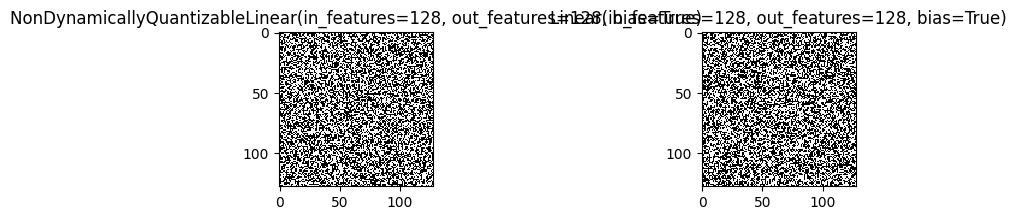

In [5]:
# Check neuron activations in each linear layer
# We want to make sure that no column is all 0s, because that would indicate a dead neuron
linear_layers = [i for i in model._modules['transformer'].modules() if isinstance(i, torch.nn.Linear)]

subset = 2
linear_layer_subset = linear_layers[:subset]
n_layers = len(linear_layer_subset)

fig, ax = plt.subplots(1, n_layers, figsize=(10, 2))
for ix, layer in enumerate(linear_layer_subset):
    abs_weights = layer.weight.detach().cpu().numpy()
    ax[ix].imshow(abs_weights > 0, cmap='gray', interpolation='nearest');
    ax[ix].set_title(str(layer))

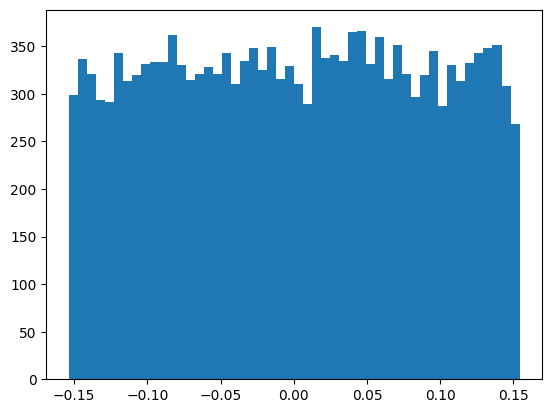

In [6]:
plt.hist(linear_layers[0].weight.view(-1).detach().cpu().numpy().tolist(), 50);

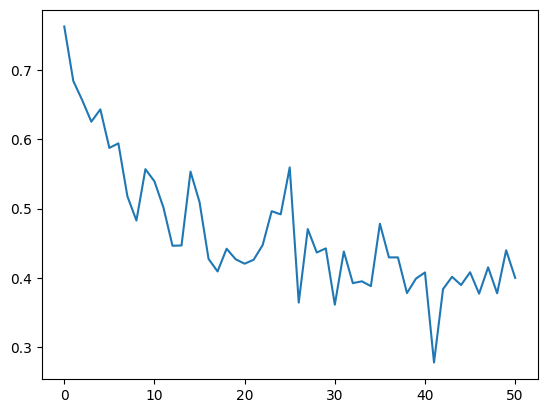

In [10]:
plt.plot(log_losses);

Text(0.5, 1.0, 'activation distribution')

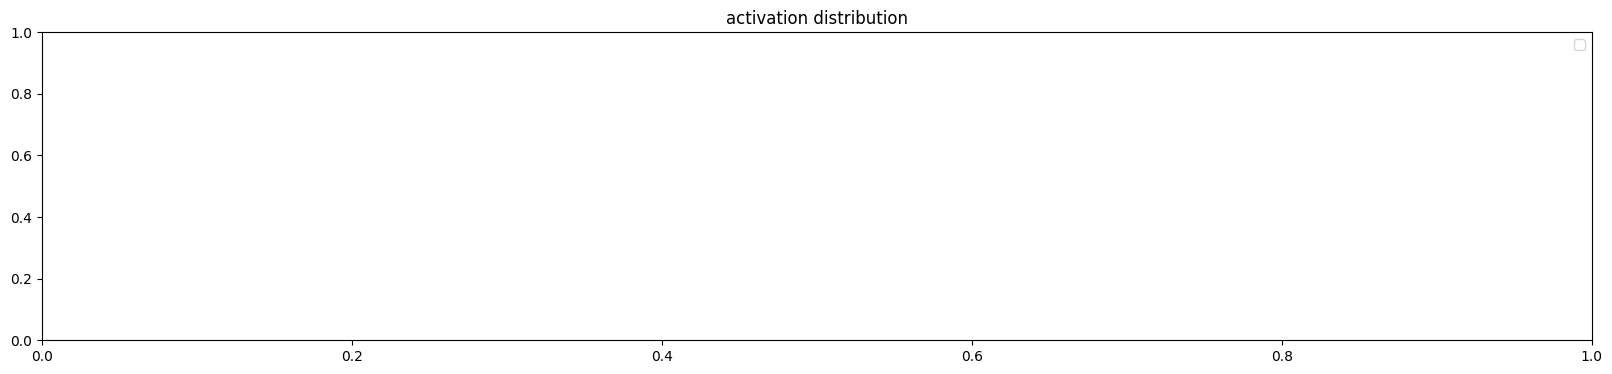

In [11]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []

for ix, layer in enumerate(linear_layers):
    if isinstance(i, torch.nn.ReLU):
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (ix, t.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(layer.weight.detach(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {ix} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

---
Total number of parameters: 2816098


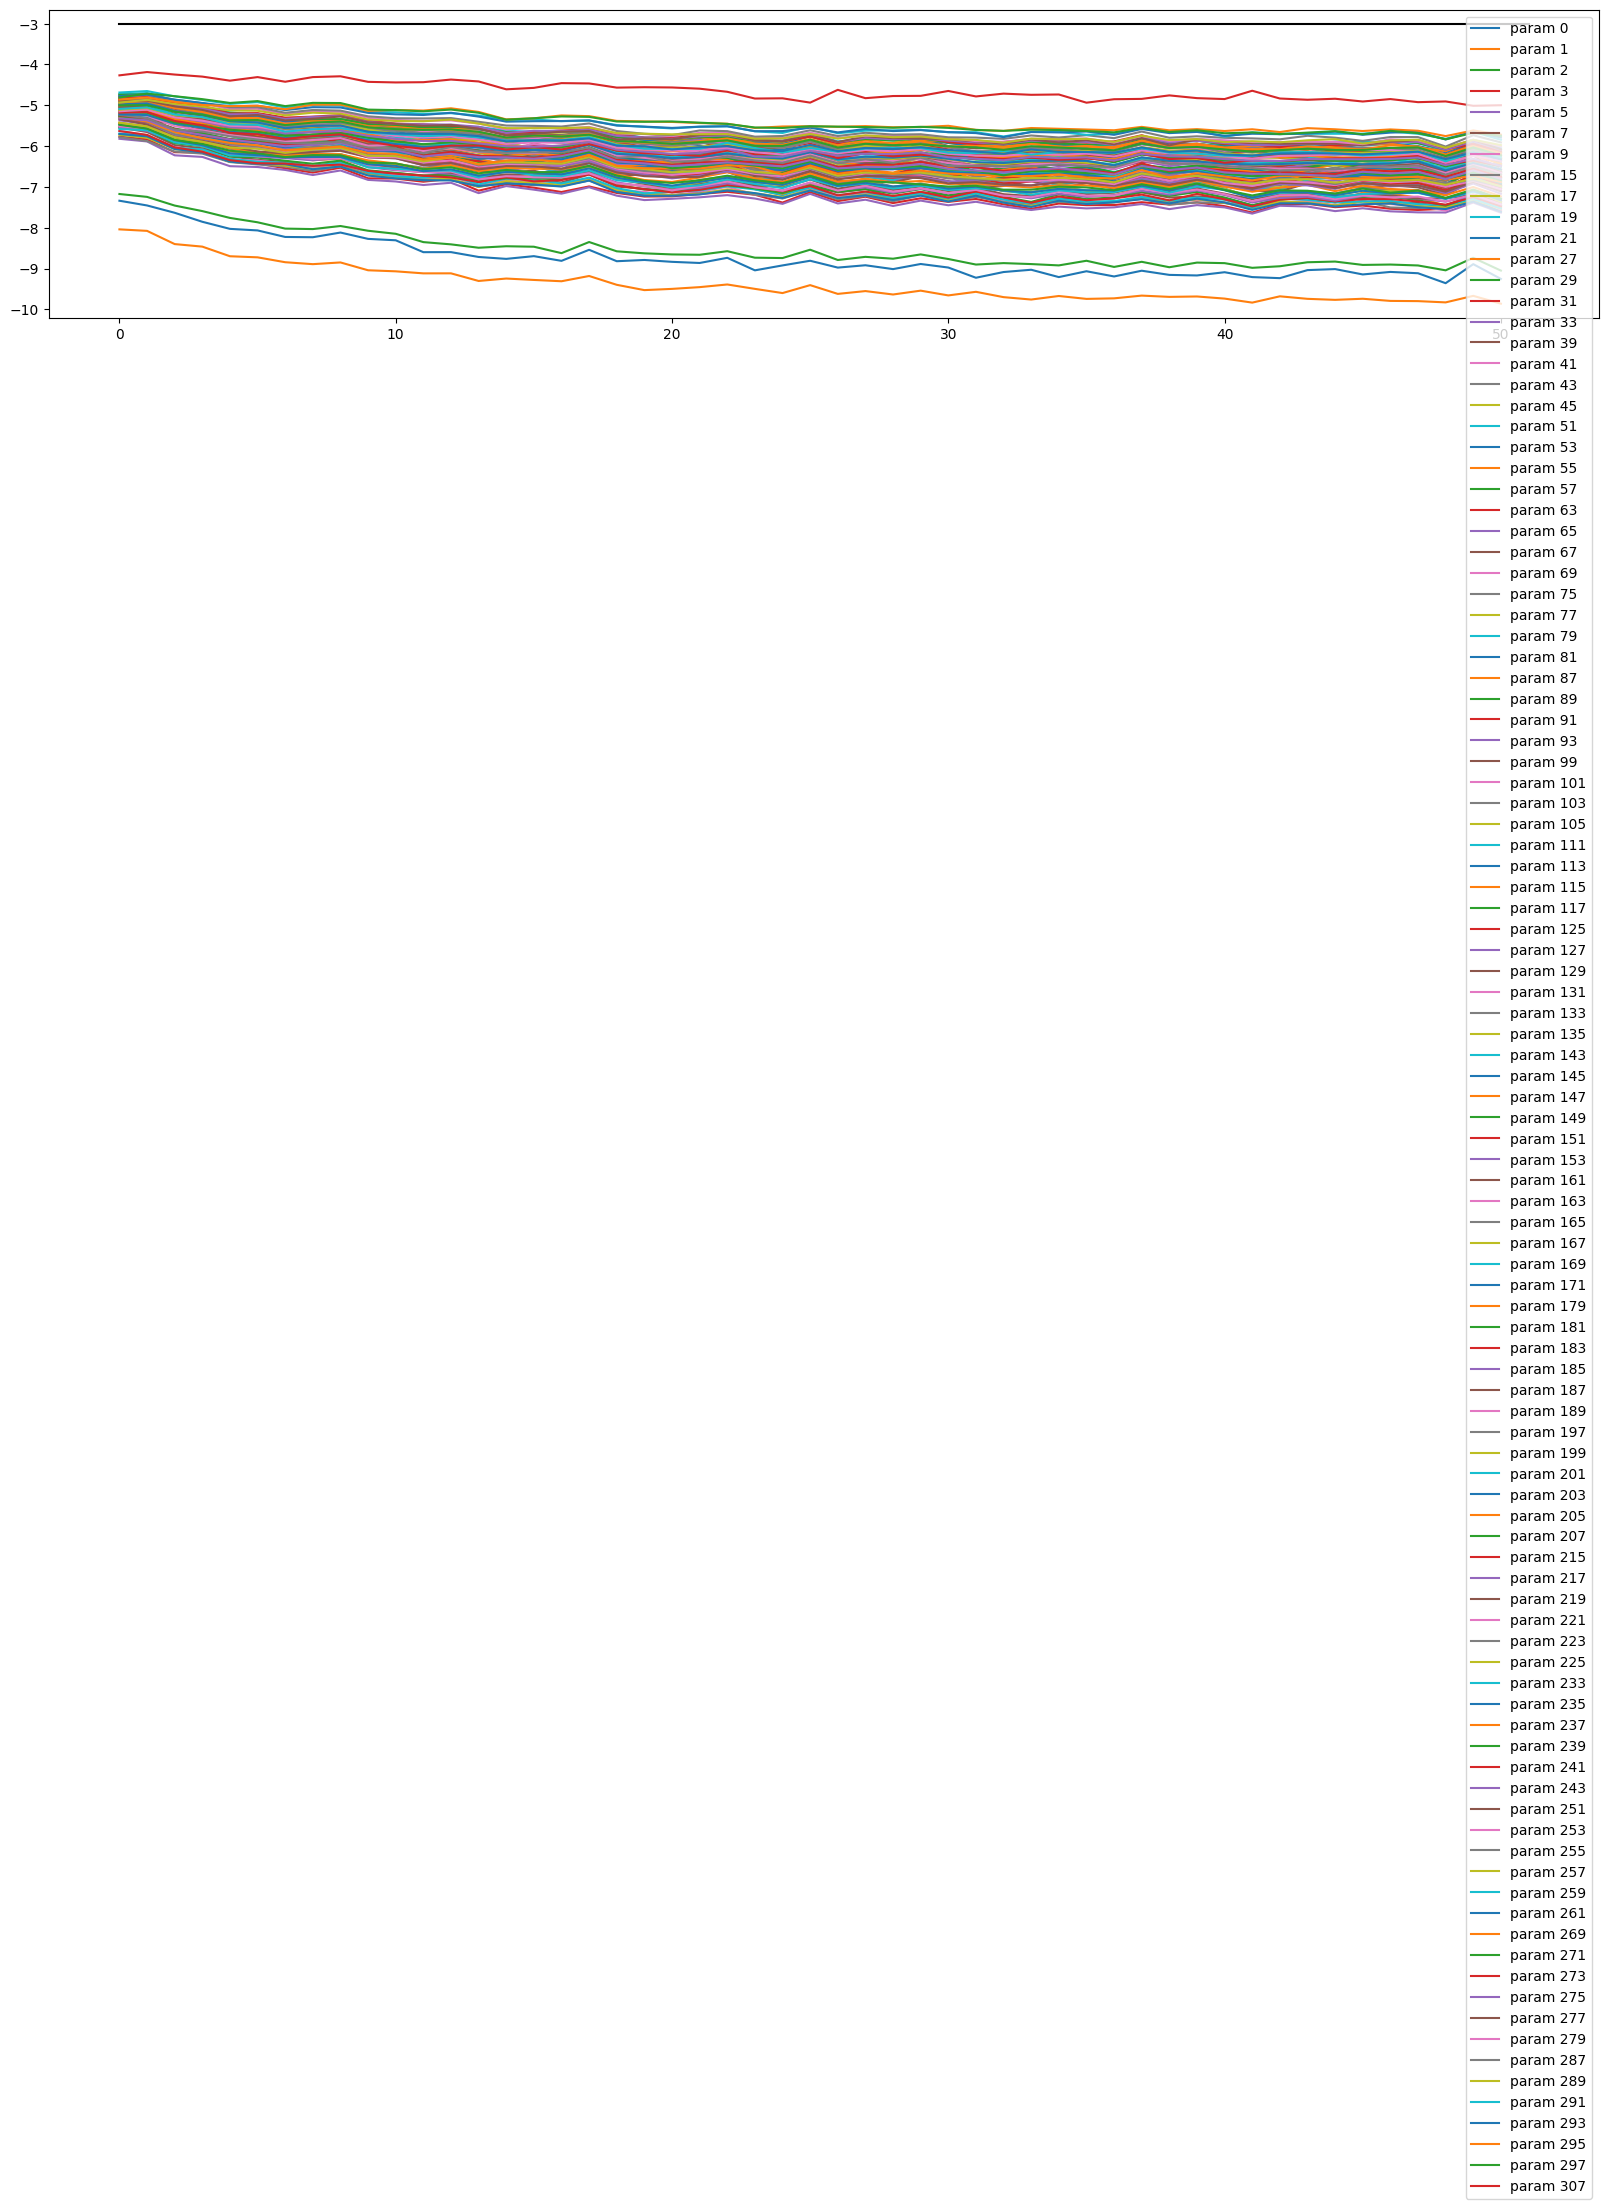

In [12]:
plt.figure(figsize=(20, 4))
legends = []

print(f'---\nTotal number of parameters: {n_params}')
for i, (pname, p) in enumerate(model.named_parameters()):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
# Stanford CS231n states that the ratio of weights:updates should be roughly 1e-3
# See https://cs231n.github.io/neural-networks-3/#ratio
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);